Imports

In [1]:
import os
from google.colab import drive
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

%matplotlib inline

Load and preprocess images

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_dir = '/content/drive/MyDrive/Capstone/multi-label/train'

In [4]:
#Load list of file paths by creating tensorflow dataset

list_ds = tf.data.Dataset.list_files(os.path.join(base_dir, '**', '*.jpg'), shuffle=True)

In [5]:
#Compute number of elements in tensorflow dataset and store in a numpy array

image_count = tf.data.experimental.cardinality(list_ds).numpy()

In [6]:
#Create train, validation and test datasets

test_size = int(image_count * 0.2)
train_val_ds = list_ds.skip(test_size)
test_ds = list_ds.take(test_size)
val_size = int((image_count-test_size) * 0.2)
train_ds = train_val_ds.skip(val_size)
val_ds = train_val_ds.take(val_size)

In [7]:
#Define batch size and dimensions of input images for the model

batch_size = 20
img_height = 160
img_width = 128

In [8]:
#Define helper functions for image label pairs

#Take labels from 'x'in the form of a byte string and encode into a tuple of integers representing the two classes (1) period (i.e. 18th century or present); (2) type of artefact (e.g. dress or watercolor)
def encode_combined_class(x):
  if x == b'eighteenth_dress':
    y = (0, 0)
  elif x == b'eighteenth_watercolor':
    y = (0, 1)
  elif x == b'present_dress':
    y = (1, 0)
  else: # b'present_watercolor'
    y = (1, 1)
  return y

#Take encoded label 'x' as tuple of integers and decodes it into a byte string label for interpretation of the predicted outputs of the model
def decode_combined_class(x):
  if x == (0, 0):
    y = b'eighteenth_dress'
  elif x == (0, 1):
    y = b'eighteenth_watercolor'
  elif x == (1, 0):
    y = b'present_dress'
  else: # (1, 1)
    y = b'present_watercolor'
  return y

#Return the label as tuple of integers
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  label = encode_combined_class(parts[-2])
  # Integer encode the label
  return label

#Take in images and resize the images to the desired dimensions.
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

#Obtain tuple of decoded image and corresponding label
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [9]:
#Use Dataset.map to create a dataset of image, label pairs:

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [10]:
# Group images and labels into batches of 'batch_size'

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

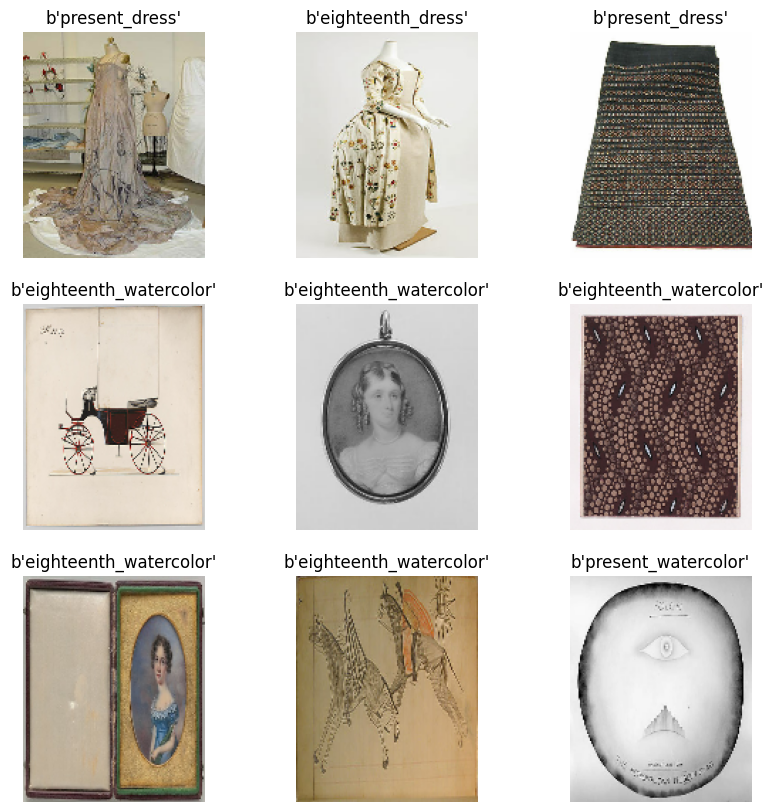

In [11]:
#Show the first nine images and labels from the training set:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label = (labels[0][i].numpy(), labels[1][i].numpy())
    plt.title(decode_combined_class(label))
    plt.axis("off")

Data Augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
#Define input shape of the model
input_images = tf.keras.Input(shape=(img_height, img_width, 3), dtype='float32', name='images')
#Apply data augementation to input images 
input_images = data_augmentation(input_images) 


#Define sequential model for 'period'
period_model = tf.keras.models.Sequential(name = 'period')
period_model.add(tf.keras.layers.Conv2D(32, (11, 11), strides=(4, 4), activation='relu', input_shape=(img_height, img_width, 3),
                                    padding='same'))
period_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
period_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
period_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
period_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
period_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
period_model.add(tf.keras.layers.Flatten())
period_model.add(tf.keras.layers.Dropout(0.5))
period_model.add(tf.keras.layers.Dense(img_width, activation='relu'))
period_model.add(tf.keras.layers.Dropout(0.5))
period_model.add(tf.keras.layers.Dense(2))
 
period_output = period_model(input_images)

#Load the pre-trained VGG16 model 
conv_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
conv_base.trainable = False

#Apply 'Type' model to the augmented input images to obtain type output
type_model = tf.keras.models.Sequential(name = 'type')
type_model.add(conv_base)
type_model.add(tf.keras.layers.Flatten())
type_model.add(tf.keras.layers.Dropout(0.25))
type_model.add(tf.keras.layers.Dense(256, activation='relu'))
type_model.add(tf.keras.layers.Dropout(0.25))
type_model.add(tf.keras.layers.Dense(2))
 
type_output = type_model(input_images)

#Define complete model for 'period' and 'type' classification 
model = tf.keras.models.Model(input_images, (period_output, type_output))

In [ ]:
#Compile the model before training it
model.compile(
    loss={
        'period': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        'type': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    },
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

In [ ]:
#Examine the model
model. summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 period (Sequential)            (None, 2)            231298      ['input_2[0][0]']                
                                                                                                  
 type (Sequential)              (None, 2)            17336898    ['input_2[0][0]']                
                                                                                                  
Total params: 17,568,196
Trainable params: 2,853,508
Non-trainable params: 14,714,688
________

In [ ]:
#Train the model
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
136/136 [==============================] - 22s 114ms/step - loss: 6.5865 - period_loss: 5.7595 - type_loss: 0.8270 - period_accuracy: 0.5347 - type_accuracy: 0.9576 - val_loss: 0.8880 - val_period_loss: 0.6928 - val_type_loss: 0.1952 - val_period_accuracy: 0.6012 - val_type_accuracy: 0.9867
Epoch 2/10
136/136 [==============================] - 10s 75ms/step - loss: 1.4023 - period_loss: 1.0613 - type_loss: 0.3410 - period_accuracy: 0.5554 - type_accuracy: 0.9786 - val_loss: 0.7286 - val_period_loss: 0.6731 - val_type_loss: 0.0555 - val_period_accuracy: 0.5465 - val_type_accuracy: 0.9956
Epoch 3/10
136/136 [==============================] - 10s 74ms/step - loss: 0.9802 - period_loss: 0.7219 - type_loss: 0.2583 - period_accuracy: 0.5749 - type_accuracy: 0.9867 - val_loss: 0.7060 - val_period_loss: 0.6340 - val_type_loss: 0.0720 - val_period_accuracy: 0.6337 - val_type_accuracy: 0.9970
Epoch 4/10
136/136 [==============================] - 8s 62ms/step - loss: 0.8718 - period_lo

Learning curves

In [ ]:
def plot_training_history(history):
    period_acc = history.history['period_accuracy']
    val_period_acc = history.history['val_period_accuracy']
    period_loss = history.history['period_loss']
    val_period_loss = history.history['val_period_loss']
    type_acc = history.history['type_accuracy']
    val_type_acc = history.history['val_type_accuracy']
    type_loss = history.history['type_loss']
    val_type_loss = history.history['val_type_loss']
    epochs = range(len(period_acc))
 
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, period_acc, 'bo', label='Period training acc')
    plt.plot(epochs, val_period_acc, 'b', label='Period validation acc')
    plt.plot(epochs, type_acc, 'ro', label='Type training acc')
    plt.plot(epochs, val_type_acc, 'r', label='Type validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.subplot(1, 2, 2)
    plt.plot(epochs, period_loss, 'bo', label='Period training loss')
    plt.plot(epochs, val_period_loss, 'b', label='Period validation loss')
    plt.plot(epochs, type_loss, 'ro', label='Type training loss')
    plt.plot(epochs, val_type_loss, 'r', label='Type validation loss')
    plt.title('Training and validation loss')
    plt.legend()
 
    plt.show()

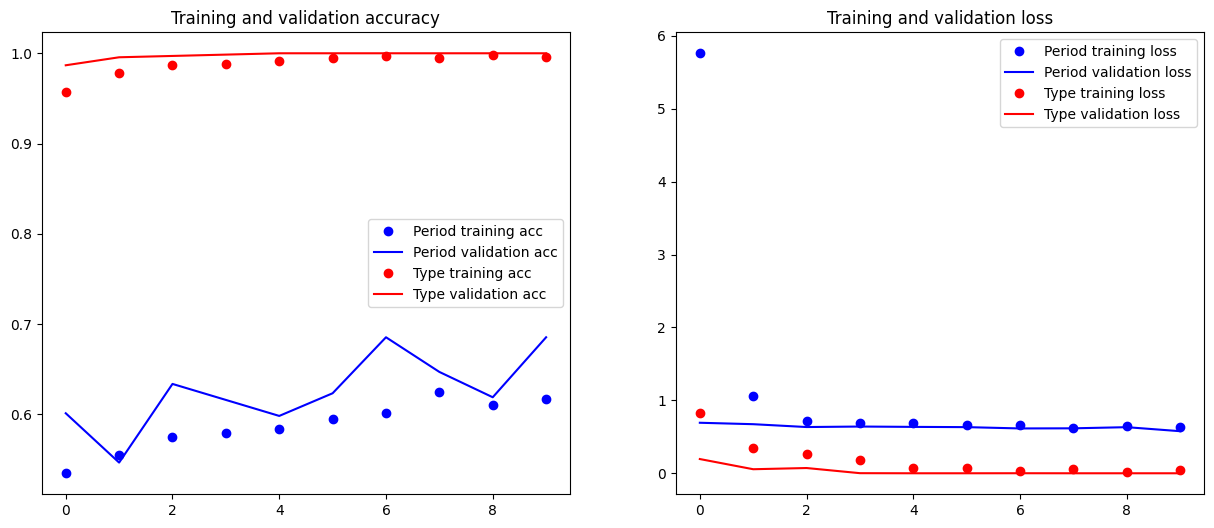

In [ ]:
plot_training_history(history)

In [ ]:
# Save the entire model.
# model.save('/content/drive/MyDrive/Capstone/multi-label/models_multilabel/model1_multilabel.h5')

In [13]:
#Reload the fresh keras model
model = tf.keras.models.load_model('/content/drive/MyDrive/Capstone/multi-label/models_multilabel/model1_multilabel.h5')

# Check its architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 period (Sequential)            (None, 2)            231298      ['input_2[0][0]']                
                                                                                                  
 type (Sequential)              (None, 2)            17336898    ['input_2[0][0]']                
                                                                                                  
Total params: 17,568,196
Trainable params: 2,853,508
Non-trainable params: 14,714,688
________

Fine tuning

In [ ]:
#Unfreeze the top layer fo the model and set bottom layers to be untrainable
conv_base.trainable = True
 
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
#Compile the model
model.compile(loss={
    'period': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'type': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    },
    loss_weights={'period': 0.1, 'type': 1.},
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=['accuracy'])
 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 period (Sequential)            (None, 2)            231298      ['input_2[0][0]']                
                                                                                                  
 type (Sequential)              (None, 2)            17336898    ['input_2[0][0]']                
                                                                                                  
Total params: 17,568,196
Trainable params: 2,853,508
Non-trainable params: 14,714,688
________

In [ ]:
#Continue training the model
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

Epoch 1/5
136/136 [==============================] - 14s 80ms/step - loss: 0.1002 - period_loss: 0.6095 - type_loss: 0.0393 - period_accuracy: 0.6443 - type_accuracy: 0.9963 - val_loss: 0.0570 - val_period_loss: 0.5700 - val_type_loss: 7.2193e-08 - val_period_accuracy: 0.7105 - val_type_accuracy: 1.0000
Epoch 2/5
136/136 [==============================] - 11s 81ms/step - loss: 0.0982 - period_loss: 0.6021 - type_loss: 0.0380 - period_accuracy: 0.6443 - type_accuracy: 0.9967 - val_loss: 0.0570 - val_period_loss: 0.5695 - val_type_loss: 3.0546e-05 - val_period_accuracy: 0.7120 - val_type_accuracy: 1.0000
Epoch 3/5
136/136 [==============================] - 9s 69ms/step - loss: 0.0785 - period_loss: 0.6011 - type_loss: 0.0184 - period_accuracy: 0.6506 - type_accuracy: 0.9985 - val_loss: 0.0566 - val_period_loss: 0.5659 - val_type_loss: 2.1084e-05 - val_period_accuracy: 0.7208 - val_type_accuracy: 1.0000
Epoch 4/5
136/136 [==============================] - 11s 82ms/step - loss: 0.0887 - pe

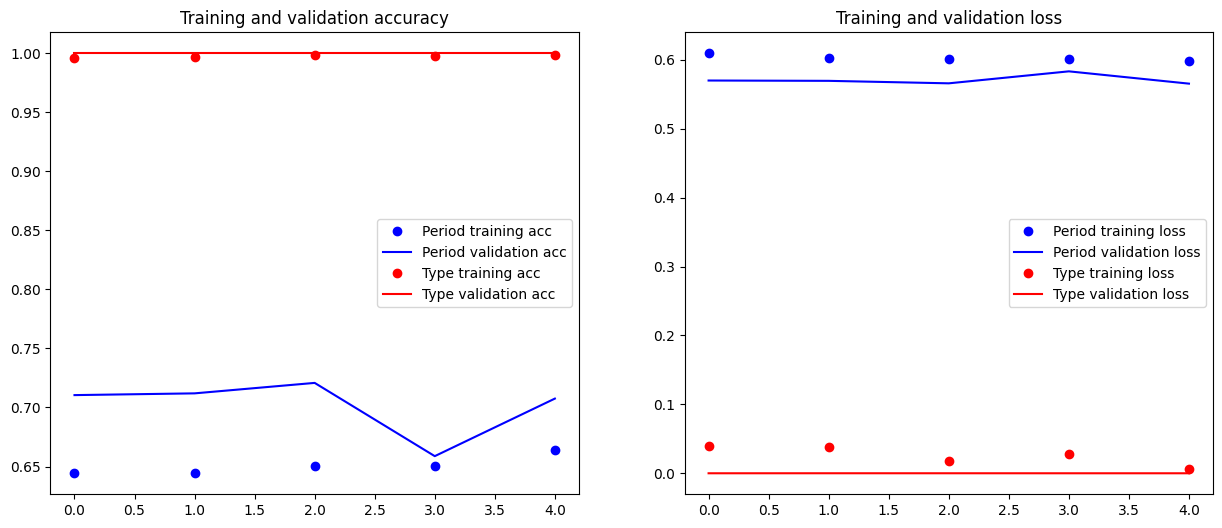

In [ ]:
plot_training_history(history)

In [14]:
#Reload the fresh keras model
model = tf.keras.models.load_model('/content/drive/MyDrive/Capstone/multi-label/models_multilabel/model2_multilabel.h5')

# Check its architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 period (Sequential)            (None, 2)            231298      ['input_2[0][0]']                
                                                                                                  
 type (Sequential)              (None, 2)            17336898    ['input_2[0][0]']                
                                                                                                  
Total params: 17,568,196
Trainable params: 2,853,508
Non-trainable params: 14,714,688
________

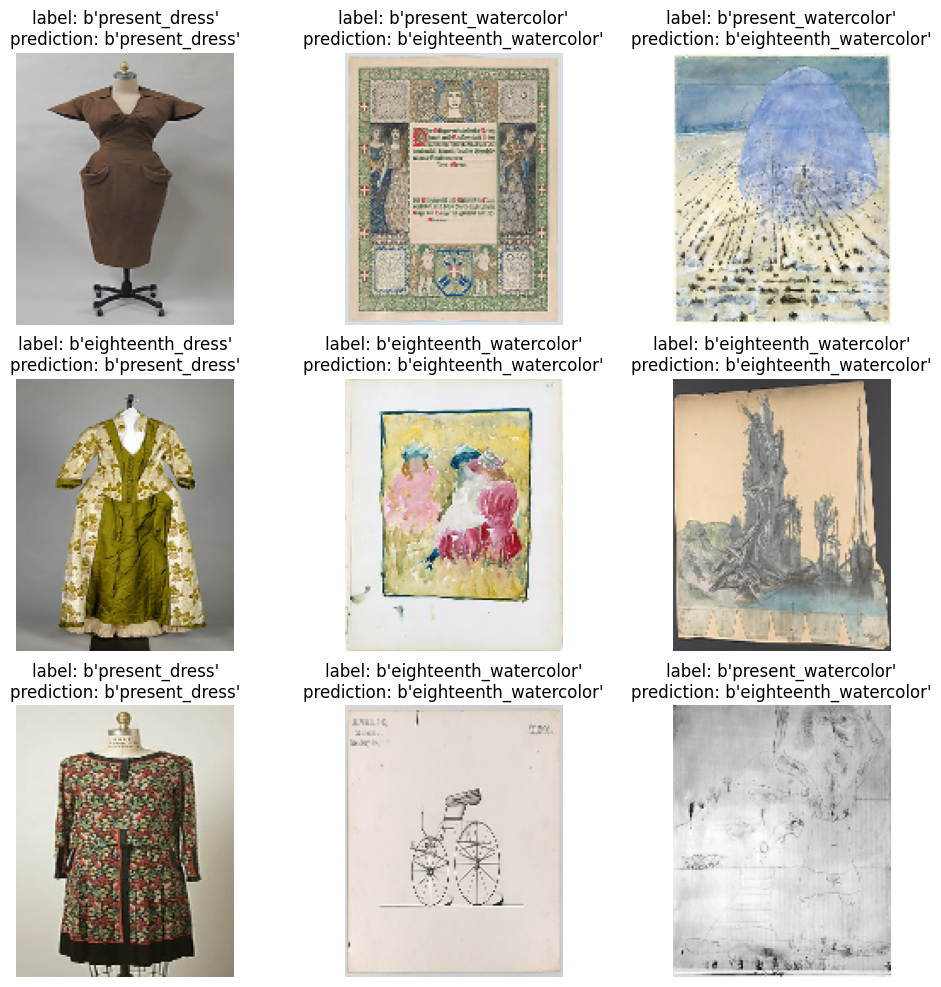

In [15]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.math.softmax(predictions)
predictions = tf.math.argmax(predictions)

plt.figure(figsize=(12, 12))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  label = (label_batch[0][i], label_batch[1][i])
  label = decode_combined_class(label)
  prediction = (predictions[i][0], predictions[i][1])
  prediction = decode_combined_class(prediction)
  plt.title('label: ' + str(label) + '\nprediction: ' + str(prediction))
  plt.axis("off")

Confusion matrix

In [16]:
y_pred = model.predict(test_ds)
y_pred = tf.math.softmax(y_pred)
y_pred = tf.math.argmax(y_pred)
y_pred = y_pred.numpy()
y_true = [label for image, label in test_ds]
y_true = np.concatenate(y_true, axis=1)
y_true = np.transpose(y_true)
cm = multilabel_confusion_matrix(y_true, y_pred)
cm

43/43 [==============================] - 255s 6s/step


array([[[214, 170],
        [248, 214]],

       [[194, 217],
        [190, 245]]])

Accuracy score for period: 0.5059
Accuracy score for type: 0.5189

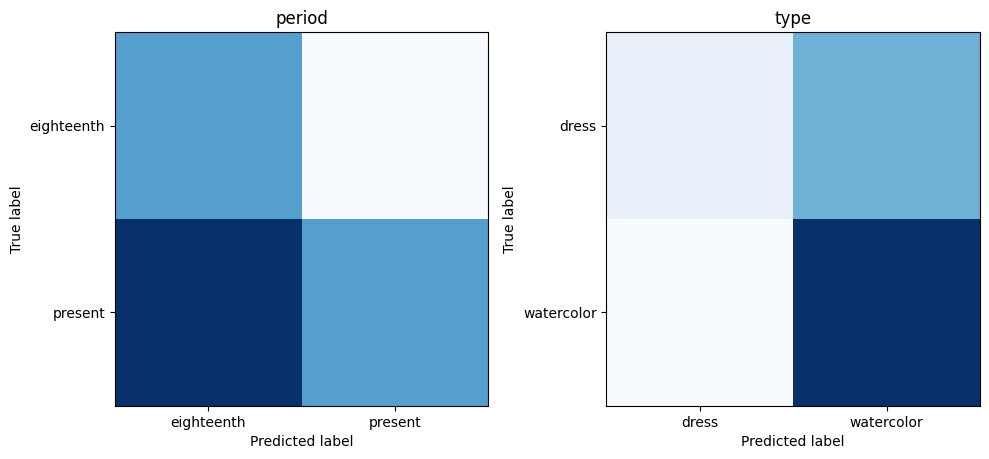

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
parts = ['period', 'type']
part_labels = {'period': ['eighteenth', 'present'], 'type': ['dress', 'watercolor']}
for i, ax in enumerate(axs.flat):
    ax.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
    ax.set(xticks=[0, 1], yticks=[0, 1],
           xticklabels=part_labels[parts[i]], yticklabels=part_labels[parts[i]],
           xlabel='Predicted label', ylabel='True label')
    ax.set_title(parts[i])
plt.tight_layout()
plt.show()

In [ ]:
# Save the entire model.
# model.save('/content/drive/MyDrive/Capstone/multi-label/models_multilabel/model2_multilabel.h5')

#Conclusion and Recommendations

##Limitations:
- Limited dataset
- Lack of interpretability
- Complex systems in archaeology and cultural complexity

##Conclusion:
1) Results for the image classification system are promising.
- 81% accuracy in predicting tags for the various artefacts (classes) for the multi-class system
- Moderate accuracy for both ‘period’ and ‘type’ outputs for the multi-label system

2) Further improvements and finetuning could be explored to optimize the model's performance

3) Results highlight the potential of using image classification models for cataloguing for artefacts for museums locally and internationally.